# Creation of maps with the extracted datasets

In [27]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle
from tqdm import tqdm
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import shapely.wkt
from shapely.geometry import Point, Polygon
import pysal

import re

from scipy import stats

from branca.colormap import linear

import folium
import folium.plugins as plugins
from folium.plugins import MarkerCluster, FastMarkerCluster, HeatMapWithTime, TimeSliderChoropleth
from folium import IFrame

## Create basic event map with geopandas

In [54]:
with open('conflict.pickle', 'rb') as data_source:
    conflict_df = pickle.load(data_source)

In [55]:
geometry = conflict_df['geom_wkt'].map(shapely.wkt.loads)
conflict_df = conflict_df.drop('geom_wkt', axis=1)
crs = {'init': 'epsg:4326'}
conflict_gdf = gpd.GeoDataFrame(conflict_df, crs=crs, geometry=geometry)


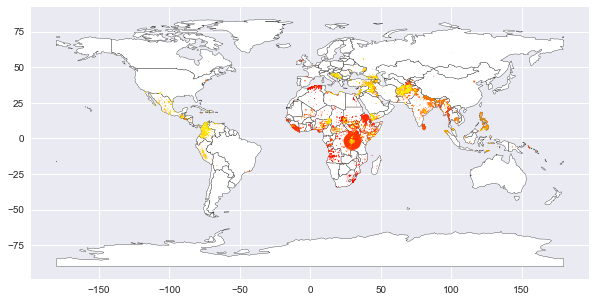

In [56]:
fig, ax = plt.subplots(figsize=(10,5))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


world.plot(ax=ax, color='white', edgecolor='black')
conflict_gdf.plot(ax=ax, markersize=(conflict_gdf.loc[:, "best"]/1000), cmap="autumn")
    
plt.show()

## Create heatmap

### Generate the event_list dataframe

In [64]:
with open('country_human_cost.pickle', 'rb') as data_source:
    country_human_cost_df = pickle.load(data_source)

In [65]:
display(conflict_df.head(1))

,id,year,type_of_violence,conflict_new_id,conflict_name,side_a_new_id,gwnoa,side_a,gwnob,side_b_new_id,...,longitude,country,country_id,date_start,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,geometry
0,4,2010,1,230,Yemen (North Yemen):Government,123,678.0,Government of Yemen (North Yemen),NaN,881,...,44.206667,Yemen (North Yemen),678,2010,2,0,0,0,2,POINT (44.206667 15.354722)


In [66]:
event_list = conflict_df[["latitude", "longitude", "best", "year"]]
display(event_list.head(2))

,latitude,longitude,best,year
0,15.354722,44.206667,2,2010
1,12.779444,45.036667,0,2011


In [67]:
# keep only events w/ deaths
event_list = event_list[event_list.best > 0]

In [68]:
event_list = event_list.sort_values("year")

In [69]:
event_list.sort_values("best", ascending = False)
display(event_list.sort_values("best").head(5))

,latitude,longitude,best,year
51579,19.461476,81.708160,1,2006
59365,6.641599,101.446521,1,2005
786,36.750000,3.666667,1,2005
59363,6.543783,101.251049,1,2005
57926,6.104253,101.893325,1,2005


### Create Heatmap with each events layered by year

In [71]:
event_df_array = []
for year in np.sort(event_list.year.unique()):
    print(year, end=", ") #make sure years are in the desired order
    event_df_array.append(event_list[event_list.year == year])

1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 

In [72]:
event_pos_date_array = []
for index in range(len(event_df_array)):
    event_pos_date_array.append([[row.latitude, row.longitude] for row in event_df_array[index].itertuples()])

In [73]:
m = folium.Map(tiles='cartodbpositron', world_copy_jump = True, no_wrap=True, zoom_start=8)

index = 0
# TODO: find good gradient color for colorblind that still show the heatmap
for index, year in enumerate(event_list.year.unique()):
    m.add_child(plugins.HeatMap(event_pos_date_array[index],
                                name="{}".format(year),
                                max_val=event_list.best.max(),
                                min_opacity=0.99,
                                radius=2,
                                blur=3,
                                max_zoom=10,
                                gradient ={0.01: 'blue', 0.04: 'cyan', 0.07: 'green', 0.15: 'yellow', 0.3:'orange', 0.5:'red',  1: 'magenta'},
                                overlay=True))


folium.LayerControl().add_to(m)
folium.plugins.Fullscreen().add_to(m)
m.save('heatmap_w_time_layered.html')

### Create a timestamped heatmap

In [74]:
NBR_OF_BINS=1000
binned_deaths, bins = pd.qcut(event_list.best, q=NBR_OF_BINS, duplicates='drop', labels=False, retbins=True)
binned_deaths.name="bin_deaths"
# We add 1 to avoid bins at 0, because they would have null weight
binned_deaths += 1
binned_deaths_df = pd.DataFrame(binned_deaths )
print(len(bins))
display(binned_deaths_df.head(5))
# Avoid doing the merge multiple times
if "bin_deaths" not in event_list.columns:
    event_list = event_list.merge(binned_deaths_df,left_index=True, right_index=True )

74


,bin_deaths
12329,53
70619,1
8732,1
8726,1
8719,1


In [75]:
bin_df_cols = ["bin", "bin_range" , "nbr"]
heatmap_bins_df = pd.DataFrame([], columns=bin_df_cols).set_index(bin_df_cols[0])

for index, value in enumerate(bins):
    min_val = bins[index-1] if index is not 0 else 0
    max_val = bins[index]
    bin_range = (min_val, max_val)
    nbr =  len(event_list.loc[event_list.bin_deaths == (index+1)])
    temp_bin_df = pd.DataFrame([[index, bin_range, nbr]], columns=bin_df_cols)
    temp_bin_df = temp_bin_df.set_index(bin_df_cols[0])
    heatmap_bins_df = heatmap_bins_df.append(temp_bin_df)
display(heatmap_bins_df.head(5))

,bin_range,nbr
bin,,
0,"(0, 1.0)",58877
1,"(1.0, 2.0)",12805
2,"(2.0, 3.0)",8473
3,"(3.0, 4.0)",6419
4,"(4.0, 5.0)",4588


In [76]:
m = folium.Map(tiles='cartodbpositron', world_copy_jump = True, no_wrap=True, zoom_start=8)

# We used bin dataset because it filters the extreme values, especially on the maximum size
# The norm isn't a 0 to 1 norm, it is a 1/bin_deaths.max() to 1, to force every event to be showed
column_to_use = "bin_deaths"
best_max = event_list[column_to_use].max()
best_min = event_list[column_to_use].min()
get_norm = lambda best: (best)/(best_max)



data_to_show = []
time_array = []
for year in event_list.year.unique():
    time_array.append(year)
    year_data = [[row.latitude, row.longitude, get_norm(row.bin_deaths)] for row in event_list.loc[event_list.year == year].itertuples()]
    data_to_show.append(year_data)
    
#data_to_show = [[row.latitude, row.longitude, get_norm(row.best)] for year in event_list.year.unique() for row in event_list.loc[event_list.year == year].itertuples()]
#display(data_to_show)
hm = plugins.HeatMapWithTime(data=data_to_show,
                             index=time_array,
                             name="deaths heatmap",
                             radius=5,
                             min_opacity=0.3,
                             max_opacity=0.9,
                             #scale_radius=True,
                             use_local_extrema=True,
                             display_index=True,
                             auto_play=True,
                             speed_step=0.1,
                             )
hm.add_to(m)

#folium.plugins.Fullscreen().add_to(m)
m.save('heatmap_w_time.html')

## Create maps with choroplets and events superposed

### Create human cost GeoDataFrame

In [97]:
with open('country_human_cost.pickle', 'rb') as data_source:
    country_human_cost_df = pickle.load(data_source)

In [98]:
display(country_human_cost_df.head(5))

number_of_events                         events_id  \
year   country_id                                                       
1989.0 2.0                        0                                 0   
       20.0                       0                                 0   
       31.0                       0                                 0   
       40.0                       0                                []   
       41.0                       4  [186087, 186122, 186123, 186124]   

                   displacement_extern  displacement_intern  \
year   country_id                                             
1989.0 2.0                         0.0                  0.0   
       20.0                        0.0                  0.0   
       31.0                        0.0                  0.0   
       40.0                     7682.0                  0.0   
       41.0                     3344.0                  0.0   

                   total_displacement  deaths           gdp  
year   country_id                                            
1989.0 2.0                        0.0       0  22599.992143  
       20.0                       0.0       0  20700.799311  
       31.0                       0.0       0  14213.543372  
       40.0                    7682.0       0   2577.207019  
       41.0                    3344.0      48    393.347528

In [99]:
country_codes_df = pd.read_csv("countrycode.csv")
display(country_codes_df.head(5))

,Unnamed: 0,ar5,continent,cowc,cown,eu28,eurocontrol_pru,eurocontrol_statfor,fao,fips105,...,country.name.es,country.name.fr,country.name.ru,country.name.zh,eurostat,wb_api2c,wb_api3c,p4_scode,p4_ccode,wvs
0,1,ASIA,Asia,AFG,700.0,NaN,Asia,Asia/Pacific,2.0,AF,...,Afganistán,Afghanistan,Афганистан,阿富汗,AF,AF,AFG,AFG,700.0,4.0
1,2,OECD1990,Europe,NaN,NaN,NaN,Eurocontrol,ESRA North-West,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,EIT,Europe,ALB,339.0,NaN,Eurocontrol,ESRA East,3.0,AL,...,Albania,Albanie,Албания,阿尔巴尼亚,AL,AL,ALB,ALB,339.0,8.0
3,4,MAF,Africa,ALG,615.0,NaN,Africa,North-Africa,4.0,AG,...,Argelia,Algérie,Алжир,阿尔及利亚,DZ,DZ,DZA,ALG,615.0,12.0
4,5,ASIA,Oceania,NaN,NaN,NaN,Asia,Asia/Pacific,NaN,AQ,...,NaN,NaN,NaN,NaN,AS,AS,ASM,NaN,NaN,16.0


In [107]:
def extract_iso3_from_gnow(gnwo):
    try:
        iso3 = country_codes_df.loc[country_codes_df.cown == gnwo]["wb_api3c"].values[0]
    except IndexError as e:
        # 99 = Great Columbia
        # 711 = Tibet
        # 972 = Tonga
        # 973 = Tuvalu
        if not (gnwo == 99 or gnwo == 711 or gnwo == 971 or gnwo == 972 or gnwo == 973 or pd.isnull(gnwo) or gnwo == 340):
            print(e, "with gnwo: {}".format(gnwo))
        return None
    return iso3
print(extract_iso3_from_gnow(2))

USA


In [108]:
def extract_gnwo_countries_to_df():
    """Extract the countries from the gnwo and their id from the gnwo files"""
    countries_list = []
    # First gnwo file, contains id, code, name for all gnow numbers
    with open("gnwo.txt", "r") as gnow:
        for line in gnow:
            split_line = re.split(r'\t+', line)
            countries_list.append(split_line[0:3])
    countries_df = pd.DataFrame(countries_list, columns=["id", "code", "name"])
    countries_df["id"] = pd.to_numeric(countries_df["id"])
    countries_df = countries_df.drop_duplicates()
    return countries_df.set_index("id")
countries_list = extract_gnwo_countries_to_df()
display(countries_list.head(5))

,code,name
id,,
2,USA,United States of America
20,CAN,Canada
31,BHM,Bahamas
40,CUB,Cuba
41,HAI,Haiti


In [109]:
# Add code column to the country_human_cost_df
countries_codes = []
for row in country_human_cost_df.itertuples():
    countries_codes.append([row.Index[0], row.Index[1], extract_iso3_from_gnow(row.Index[1])])
countries_codes = pd.DataFrame(countries_codes, columns=["year", "country_id","country_code"]).set_index(["year", "country_id"])

In [110]:
if not "country_code" in country_human_cost_df.columns:
    country_human_cost_df = pd.concat([country_human_cost_df, countries_codes], axis=1, join_axes=[country_human_cost_df.index])
display(country_human_cost_df.head(5))

number_of_events                         events_id  \
year   country_id                                                       
1989.0 2.0                        0                                 0   
       20.0                       0                                 0   
       31.0                       0                                 0   
       40.0                       0                                []   
       41.0                       4  [186087, 186122, 186123, 186124]   

                   displacement_extern  displacement_intern  \
year   country_id                                             
1989.0 2.0                         0.0                  0.0   
       20.0                        0.0                  0.0   
       31.0                        0.0                  0.0   
       40.0                     7682.0                  0.0   
       41.0                     3344.0                  0.0   

                   total_displacement  deaths           gdp country_code  
year   country_id                                                         
1989.0 2.0                        0.0       0  22599.992143          USA  
       20.0                       0.0       0  20700.799311          CAN  
       31.0                       0.0       0  14213.543372          BHS  
       40.0                    7682.0       0   2577.207019          CUB  
       41.0                    3344.0      48    393.347528          HTI

In [112]:
#for now drop bad rows... could do something different later on
# TODO: there's buggy displacement values, fix it!
country_human_cost_df = country_human_cost_df[~country_human_cost_df.country_code.isnull()]
display(country_human_cost_df.head(5))

number_of_events                         events_id  \
year   country_id                                                       
1989.0 2.0                        0                                 0   
       20.0                       0                                 0   
       31.0                       0                                 0   
       40.0                       0                                []   
       41.0                       4  [186087, 186122, 186123, 186124]   

                   displacement_extern  displacement_intern  \
year   country_id                                             
1989.0 2.0                         0.0                  0.0   
       20.0                        0.0                  0.0   
       31.0                        0.0                  0.0   
       40.0                     7682.0                  0.0   
       41.0                     3344.0                  0.0   

                   total_displacement  deaths           gdp country_code  
year   country_id                                                         
1989.0 2.0                        0.0       0  22599.992143          USA  
       20.0                       0.0       0  20700.799311          CAN  
       31.0                       0.0       0  14213.543372          BHS  
       40.0                    7682.0       0   2577.207019          CUB  
       41.0                    3344.0      48    393.347528          HTI

In [113]:
display(country_human_cost_df.country_code.isnull().any())

False

In [114]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [ ]:
world.head(5)

In [ ]:
# Drop country for which we don't have a corresponding country code
country_code_to_drop = []
for country_code in country_human_cost_df.country_code.unique():
    if not world.iso_a3.str.contains(country_code).any():
        country_code_to_drop.append(country_code)

# Remove unrecognized countries from the dataframe
country_human_cost_df = country_human_cost_df[~country_human_cost_df.country_code.isin(country_code_to_drop)]
display(country_human_cost_df.head(5))

In [ ]:
indexed_world = world.set_index(["iso_a3"])
display(indexed_world.head(5))

In [ ]:
geometry = pd.DataFrame([], columns=["year", "country_id", "geometry"])
for row in country_human_cost_df.itertuples():
    geometry_val = indexed_world.loc[row.country_code, "geometry"]
    temp_geo = pd.DataFrame([[row.Index[0], row.Index[1], geometry_val]], columns=["year", "country_id", "geometry"])
    geometry = pd.concat([geometry, temp_geo])
display(geometry.head(5))

In [ ]:
geometry = geometry.set_index(["year", "country_id"])

In [ ]:
crs = {'init': 'epsg:4326'}
human_cost_gdf = gpd.GeoDataFrame(country_human_cost_df, crs=crs, geometry=geometry.geometry.values)

In [ ]:
display(human_cost_gdf.head(5))

In [ ]:
display(conflict_gdf.head(5))

In [ ]:
nbr_of_years = len(conflict_gdf.year.unique())
print(nbr_of_years)

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=14, figsize=(20,100))

for centered_year in tqdm(range(nbr_of_years)):
    row = centered_year // 2
    col = centered_year % 2
    conflict_gdf_subset = conflict_gdf.loc[conflict_gdf.year == 1989+centered_year]
    world.plot(ax=ax[row, col], color='white', edgecolor='black')
#    human_cost_gdf.loc[1989+centered_year].plot(ax=ax[row, col], column="total_displacement", cmap="GnBu", scheme='quantiles', legend="Displacement")
    human_cost_gdf.loc[1989+centered_year].plot(ax=ax[row, col], column="gdp", cmap="GnBu", scheme='quantiles')
    conflict_gdf_subset.plot(ax=ax[row, col], markersize=np.log2(conflict_gdf_subset.loc[:, "best"]), alpha=0.5, cmap="YlOrRd", scheme='Fisher_Jenks', legend="Event Deaths")
    ax[row, col].legend(pos=3) 
    ax[row, col].set_title("{}".format(1989+centered_year))
fig.savefig("output_maps_death_migration.png")
fig.clf()

In [ ]:
print(stats.stats.pearsonr(human_cost_gdf["total_displacement"], human_cost_gdf["deaths"]))
print(stats.stats.spearmanr(human_cost_gdf["total_displacement"], human_cost_gdf["deaths"]))
print(stats.stats.pearsonr(human_cost_gdf["gdp"], human_cost_gdf["deaths"]))
print(stats.stats.spearmanr(human_cost_gdf["gdp"], human_cost_gdf["deaths"]))

## Plot by conflict instead of singular event

In [ ]:
new_conflict_gdf = conflict_gdf[["year", "conflict_new_id", "best", "geometry" ]]
display(new_conflict_gdf.head(5))

In [ ]:
dissolved_conflict_gdf = new_conflict_gdf.dissolve(by=["year", "conflict_new_id"], aggfunc='sum')
display(dissolved_conflict_gdf.head(5))

In [ ]:
new_geometry = dissolved_conflict_gdf["geometry"].apply(lambda x: x if type(x) is Point or len(x) < 3 else Polygon([(p.x, p.y) for p in x]))
dissolved_conflict_gdf.loc[:, "geometry"] = new_geometry
display(dissolved_conflict_gdf.head(5))

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=14, figsize=(20,100))

for centered_year in tqdm(range(nbr_of_years)):
    row = centered_year // 2
    col = centered_year % 2
    conflict_gdf_subset = dissolved_conflict_gdf.loc[1989+centered_year]
    world.plot(ax=ax[row, col], color='white', edgecolor='black')
#    human_cost_gdf.loc[1989+centered_year].plot(ax=ax[row, col], column="total_displacement", cmap="GnBu", scheme='quantiles')
    human_cost_gdf.loc[1989+centered_year].plot(ax=ax[row, col], column="gdp", cmap="GnBu", scheme='quantiles', legend="GDP in USD")
    ax[row,col].legend(loc="lower left")
    conflict_gdf_subset.plot(ax=ax[row, col], column="best", markersize=10, alpha=0.9, cmap="YlOrRd")
    ax[row, col].set_title("{}".format(1989+centered_year))
    
fig.tight_layout()
fig.savefig("output_maps_conflict_death_migration.png")

fig.clf()

## Try to get into Folium

In [ ]:
dt_index = pd.date_range(start=pd.datetime(1989, 1, 1), periods=28, freq='AS').strftime('%s')
year_to_dt_index_dict = {}
for year in range(len(dt_index)):
    year_to_dt_index_dict[year+1989] = dt_index[year]
display(dt_index)

In [ ]:
# First we start with the chloropleth maps, its easier to manage
display(human_cost_gdf.head(1))

In [ ]:
def year_list_to_dt_index(year_list):
    indexes = np.subtract(year_list, 1989).astype(int)
    values = dt_index[indexes]
    return values

In [ ]:
# We will use constant opacity and variable color to represent the metrics
def get_colormap(df, column="gdp"):
    min_value = df[column].min() 
    max_value = df[column].max() 
    cmap = linear.GnBu.scale(min_value, max_value)
    return cmap

cmap_gdp = get_colormap(human_cost_gdf, "gdp")
cmap_disp = get_colormap(human_cost_gdf, "total_displacement")
cmap_deaths = get_colormap(human_cost_gdf, "deaths")

In [ ]:
display(human_cost_gdf.index.get_level_values(1))
human_cost_gdf.sort_index(inplace=True)

In [ ]:
def get_style_data(df, column="gdp", opacity=0.7, ):
    cmap = get_colormap(df, column)
    style_data_dict = {}
    nbr_of_years = len(dt_index)
    min_color_value = "#ffffffff" 
    for country in df.index.get_level_values(1).unique():
        
        years = df.loc[(slice(None), country) , :].index.remove_unused_levels().get_level_values(0)
        
        partial_color_list = df.loc[(slice(None), country), column].apply(cmap).values
        partial_opacity_list = np.full(nbr_of_years, opacity)
        color_list = np.full(nbr_of_years, min_color_value)
        for index, year in enumerate(years):
            color_list[np.where(dt_index == year_to_dt_index_dict[year])] = partial_color_list[index]
        opacity_list = np.full(nbr_of_years, opacity)
        
        local_df = pd.DataFrame(
            {'color' : color_list,
             'opacity' : opacity_list},
             index=dt_index
        )
        local_df = local_df.sort_index()
        style_data_dict[str(int(country))] = local_df.to_dict(orient='index')
    return style_data_dict

In [ ]:
only_country_gdf = human_cost_gdf.copy()
try:
    only_country_gdf.index = only_country_gdf.index.droplevel("year")
except: # If we rerun
    pass
only_country_gdf = only_country_gdf.iloc[~only_country_gdf.index.duplicated()].sort_index()
only_country_gdf = only_country_gdf.reset_index()
only_country_gdf["country_id"] = only_country_gdf["country_id"].astype(int)
only_country_gdf = only_country_gdf.set_index("country_id")
display(only_country_gdf.head(5))

In [ ]:
style_dict_gdp = get_style_data(human_cost_gdf, "gdp", 1.0)
print(len(style_dict_gdp))
display(style_dict_gdp)

In [ ]:
only_country_gdf = only_country_gdf[["total_displacement", "deaths", "gdp", "geometry"]]
only_country_json = only_country_gdf.to_json() 
print(len(only_country_gdf))

In [ ]:
m = folium.Map(tiles='cartodbpositron', world_copy_jump = True, no_wrap=True, zoom_start=5)
slider_gdp = plugins.TimeSliderChoropleth(
    only_country_json,
    styledict = get_style_data(human_cost_gdf, "gdp", 0.7),
    name="gdp"
).add_to(m)
#slider_deaths = plugins.TimeSliderChoropleth(
#    only_country_json,
#    styledict = get_style_data(human_cost_gdf, "deaths", 0.7),
#    name="deaths"
#).add_to(m)
folium.LayerControl().add_to(m)
folium.plugins.Fullscreen().add_to(m)
m.save("gdp_time_slider.html")
m